# Movie Scripts - An Analysis
### Act 1
_"Toto, I've a feeling we're not in Kansas anymore."_

I've got my hands on some 1k movie scripts in text form (courtesy of the IMSDB website), so let's explore.

### 1) Imports and data loading!


In [776]:
%matplotlib inline 

import numpy as np
import pandas as pd
import os
import re
from collections import Counter, defaultdict
from itertools import combinations
import networkx as nx
import pickle

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)


Get the file index first

In [4]:
# get the genres based on the folder names
genres = os.listdir("imsdb_raw_nov_2015/")[1:]

# store the movie names in an index so we know the genre
file_index = {}
for g in genres:
    file_index[g] = os.listdir(os.getcwd() + "/imsdb_raw_nov_2015/" + g) 

Load in all the files into a dictionary

In [5]:
movies_text = {}
genre_index = {}
# read in the files for each genre now
for g in genres:
    # within each genre, read in each movie
    for m in file_index[g]:
        movie_name = str.split(m, ".txt")[0] # just get the name, removing extension
        genre_index[movie_name] = g # dictionary lookup from movie to genre 
        fname = os.getcwd() + "/imsdb_raw_nov_2015/" + g + "/" + m # get the file path
        f = open(fname) # open the file
        movies_text[movie_name] = f.readlines() # read in the text

In [25]:
movies_sample = movies_text.keys()[1:10]

### 2) EDA

Let's do some text summary analytics on the scripts. We'll need to understand the mechanics of a movie script first:
* There are newlines everywhere - its wise to ignore these when counting lines.
* A character's name is preceeded with two tabs so that it sits in the middle of the page. we can use this to count exchanges.
* Lines that start with INT. or EXT. set the scene. We can use this to count how descriptive a script is.



We'll start with a basic dataframe.

In [67]:
movies_df = pd.DataFrame({
        "movie": movies_text.keys(),
        "text": movies_text.values(),
        "genre": genre_index.values()
    })


In [785]:
pickle.dump(movies_df, open("movies_df.pkl", "wb"))

Let's see the genre distribution:

In [125]:
movies_df.groupby("genre").count().movie.sort_values(ascending = False)

genre
Thriller     366
Drama        211
Romance      150
Sci-Fi        79
Comedy        68
Fantasy       38
Horror        26
War           26
Crime         21
Mystery       21
Musical       16
Western       13
Family        11
Adventure      6
Action         4
Film-Noir      3
Music          3
Short          3
History        2
Animation      2
Sport          1
Name: movie, dtype: int64

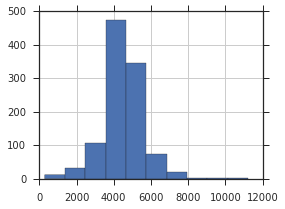

In [131]:
movies_df['condensed_text'] = movies_df.text.map(lambda t: [l for l in t if l != "\n"])
movies_df['length'] = movies_df.condensed_text.map(len) # count all non-newline lines
movies_df.length.hist(figsize=(4,3))
plt.show()

Pretty normal curve, except for some right tailed outliers. Let's see if this varies by genre.

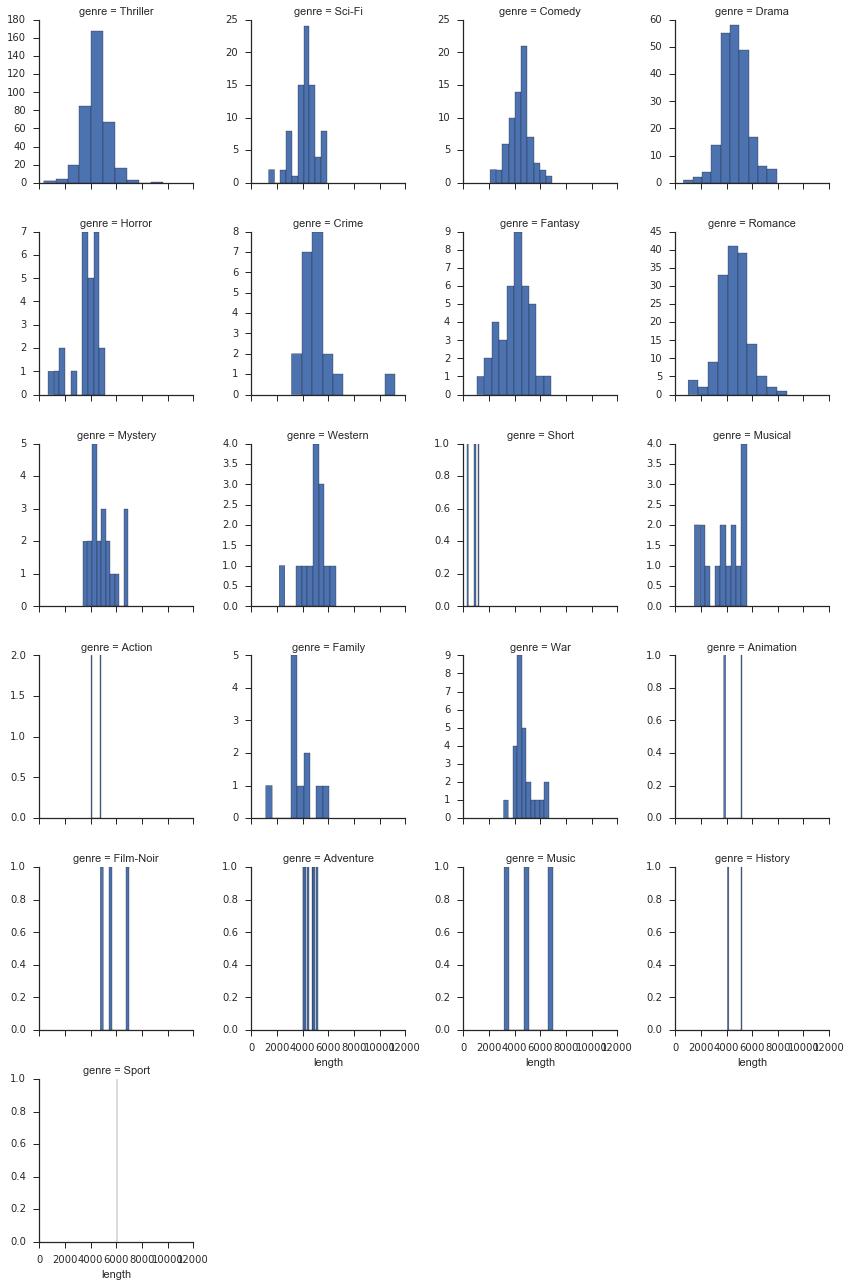

In [87]:
g = sns.FacetGrid(movies_df, col = "genre", col_wrap=4, sharey = False, )
g = g.map(plt.hist, "length")

Distributions don't look terribly different, though we can't say so with statistical certainty. Let's see if **intensity** is higher by counting question marks and exclamation marks.

In [105]:
movies_df['qmarks'] = movies_df.text.map(lambda t: (''.join(t)).count("?"))
movies_df['emarks'] = movies_df.text.map(lambda t: (''.join(t)).count("!"))

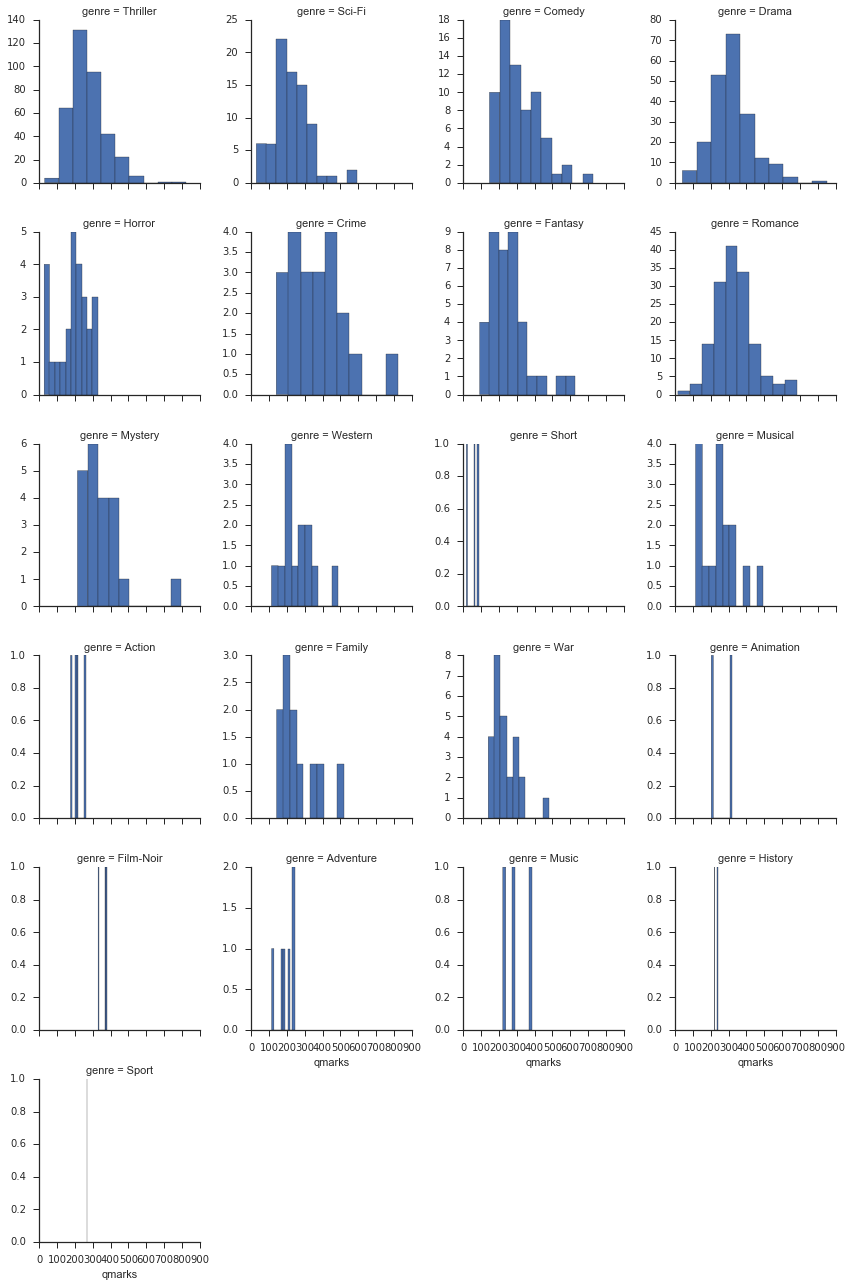

In [782]:
g = sns.FacetGrid(movies_df, col = "genre", col_wrap=4, sharey = False)
g = g.map(plt.hist, "qmarks")

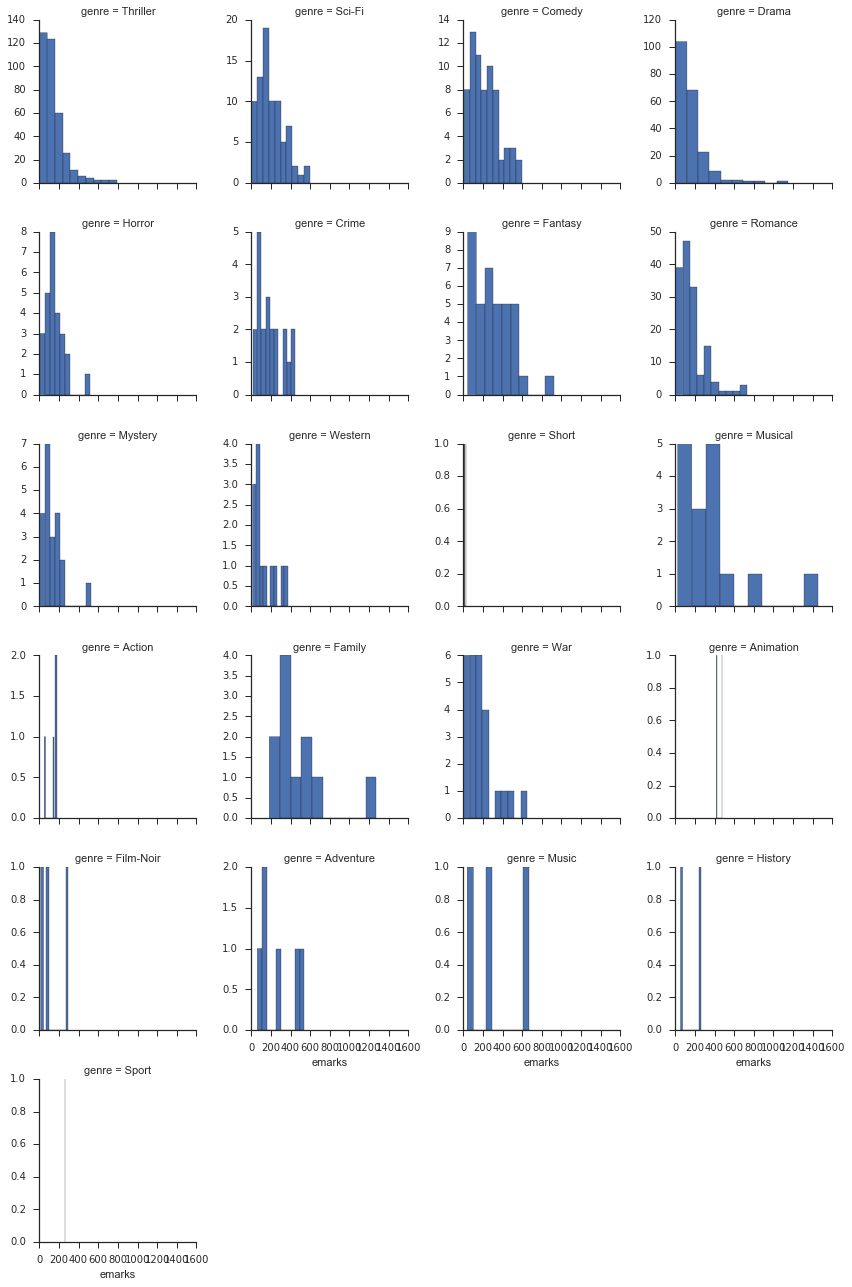

In [111]:
g = sns.FacetGrid(movies_df, col = "genre", col_wrap=4, sharey = False)
g = g.map(plt.hist, "emarks")

Now we need to derive semantic understanding from the scripts. To do so, we want to associate each stage direction or dialogue with a setting or character, respectively.

In [ ]:
movies_df['string_text'] = movies_df.condensed_text.map(lambda t: ''.join(t))

** Let's analyze the first movie on the list, _V for Vendetta_ **! 

In [423]:
mov1 = movies_df.condensed_text[0][7:] # take first script from beginning, 
lspaces = [len(l) - len(l.lstrip()) for l in mov1] # count leading spaces
mov1 = [l.strip() for l in mov1] # take out the spaces on both sides

In [424]:
zip(lspaces, mov1)[:100]

[(30, 'EVEY (V.O.)'),
 (20, '"Remember, remember, the fifth of'),
 (20, 'November, the gunpowder treason and'),
 (20, 'plot.  I know of now reason why the'),
 (20, 'gunpowder treason should ever be'),
 (20, 'forgot."'),
 (10, 'Her voice has a strength that is metered by a calmness, a'),
 (10, 'deep centered peace that we can feel.'),
 (30, 'EVEY (V.O.)'),
 (20, 'Those were almost the very first'),
 (20, 'words he spoke to me and, in a way,'),
 (20, 'that is where this story began,'),
 (20, 'four hundred years ago, in a cellar'),
 (20, 'beneath the Houses of Parliament.'),
 (10, 'In the darkness, we find a lantern.  Guy Fawkes, a dangerous'),
 (10, 'man who wears a goatee, is struggling with a wheelbarrow'),
 (10, 'stacked with barrels of gunpowder.'),
 (30, 'EVEY (V.O.)'),
 (20, 'In 1605, Guy Fawkes attempted to'),
 (20, 'blow up the Houses of Parliament.'),
 (10, 'The wheelbarrow bumps over the heavy stone mortar of the'),
 (10, 'cellar floor.  From the dark depths, we hear the sound 

We notice we can use leading space count to determine line type:
* 10 leading spaces == action
* 20 leading spaces == dialogue
* 30 leading spaces == character

Let's tag every line by its type: if it marks a new scene, then it starts with the slug line - INT. (interior) or EXT. (exterior). If it fades, we can ignore because it doesn't reliably mark the beginning or end of an new scene. For the rest, we'll use leading spaces.

In [425]:
scene_markers = {"FADE IN": "ignore",
    "FADE OUT": "ignore", 
    "DISSOLVE TO": "ignore",
    "INT.": "scene",
    "EXT.": "scene"}

In [426]:
markers = [None] * len(mov1) # initialize empty list of same length as script
for i in range(len(mov1)): # for each index, 
    line = mov1[i] # grab the line
    if any([k in line for k in scene_markers]): # if any of the scene markers are present in the line, 
        for k in scene_markers: # for each scene marker
            if k in line: # if its in the line, 
                markers[i] = scene_markers[k] # mark it accordingly
    # now start countling leading spaces
    elif lspaces[i] == 10: 
        markers[i] = "action" 
    elif lspaces[i] == 20: 
        markers[i] = "dialogue"
    elif lspaces[i] == 30: # character
        markers[i] = "character" # remove the voiceover tag if necessary
        mov1[i] = re.sub("\(V.O.\)", "", line).strip() # update the character name to be without the V.O.
    else:
        markers[i] = "other"
tagged_script = zip(mov1, markers)

Now for each scene, we know who is speaking, what their lines are, and what action is happening in the scene. 

We can ignore the action (for now) and focus on the dialogue, and who's speaking it. It would be great to break down the data by scene, and have lines associated with their particular characters.

In [428]:
# prepend a start line to denote its the beginning of the script.
tagged_script = [("BEGIN", "scene")] + tagged_script

In [429]:
scenes = list()
scene = list()
for line, tag in tagged_script: # comb through the entire script
    if tag == "scene": # if a new scene begins, 
        scenes.append(scene)
        scene = list() # start a new scene
        dialogue_num = -1 # begin counting dialogue numbers (start below 0)
    else: # otherwise
        if tag == "character":
            character = line # save the char name
            scene.append((character, "")) # create a new tuple with element 1 being char, element 2 being their dialogue
            dialogue_num += 1 # increment the dialogue counter to know who's dialogue to update
        if tag == "dialogue": # for dialogues, 
            scene[dialogue_num] = (character, scene[dialogue_num][1] + " " + line) # update characters line with the next one.
            
scenes = scenes[1:] # the first scene is empty.

In [630]:
scenes = [scene for scene in scenes if len(scene) > 0] # get rid of empty scenes
scenes[16:18] # take a look at a few.

[[('EVEY', ' Why did you do that?  Why did you... help me?'),
  ('V', ' Why indeed?'),
  ('V', ' Almost time.'),
  ('EVEY', ' For what?'),
  ('V', ' For the music.'),
  ('EVEY', ' Music?'),
  ('V', ' Yes, music.  My music.  You see. Evey, I am a performer.'),
  ('EVEY', " Is that why you're wearing a mask?"),
  ('V',
   ' We all wear masks.  Life creates them and forces us to find the one that fits.  Do you know what day it is?'),
  ('EVEY', ' Uh... November fourth.'),
  ('V', ' Not for long.'),
  ('V',
   ' "Remember, remember, the fifth of November, the gunpowder treason and plot.  I know of no reason why the gunpowder treason should ever be forgot."'),
  ('V',
   ' Tell me, Evey, what good is an actor that plays his part to an empty theatre?'),
  ('EVEY', " I don't know."),
  ('V',
   " Nor do I.  That's why you are here. I need you, Evey.  I need someone to listen."),
  ('EVEY', ' To your music?'),
  ('V', ' Yes.  Yes, to my music.'),
  ('V', " Can you hear it?  It's already begun.

Looking great. Now let's try to figure out some connections between characters. We'll first do a dictionary count of lines per character per exchange. 

In [457]:
scene_lines_count = [dict(Counter([line[0] for line in scene])) for scene in scenes] # count how many lines per scene
scene_lines_count[:10]

[{'EVEY': 8},
 {'EVEY': 4},
 {'EVEY': 3},
 {'DASCOMBE': 1, 'EVEY': 1},
 {'EVEY': 3, 'FATHER': 1, 'LITTLE EVEY': 2, 'MOTHER': 1},
 {'EVEY': 1},
 {'EVEY': 5},
 {'EVEY': 3, 'FATE': 2},
 {'FATE': 2},
 {'FATE': 1}]

This means that in scene one, Evey has 8 lines to herself, and 4, Dascombe has 1 and Evey has 1.

Now we can see who shares the most interactions with one another.

In [544]:
interactions = list() 
for counts in scene_lines_count: # for each scene, 
    for c1,c2 in combinations(counts.keys(), 2): # for each pair of people speaking in a scene
        pair = tuple(sorted((c1,c2))) # create a tuple of their names
        interactions.append((pair, counts[c1] + counts[c2])) # assign the counts to that tuple key

In [557]:
interaction_strength = defaultdict(int) 
for i in interactions: # for each interaction
    interaction_strength[i[0]] += i[1] # increment the pair's count with the # of lines shared in that interaction
interaction_strength = [(k,v) for k,v in interaction_strength.iteritems()] # convert to traditional dict

In [625]:
edges = sorted(interaction_strength, key = lambda t: -t[1])
edges[:5]

[(('EVEY', 'V'), 246),
 (('FINCH', 'LEADER'), 125),
 (('DOMINIC', 'FINCH'), 74),
 (('CAPTAIN', 'LEADER'), 52),
 (('CONRAD', 'HELEN'), 50)]

Evey and V have the most lines together, which Finch and the Leader have the next. Fascinating stuff! Now we can build out an actual network using these as the edges.

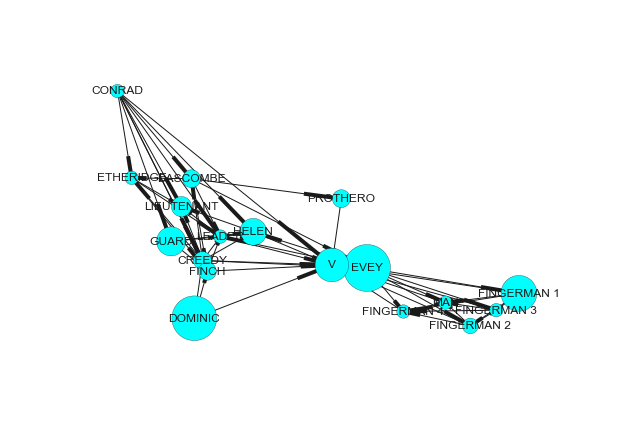

In [737]:
g = nx.DiGraph((x, y, {"weight": v}) for ((x, y), v) in edges)
d = g.degree()
d = [(k,v) for (k,v) in sorted(d.iteritems(), key=lambda (k,v): -v)]
sub_g = g.subgraph([n for (n,o) in d][:18])
nx.draw(sub_g, with_labels=True, font_size=12, node_color="cyan", node_size=[5*o**2 for (n,o) in d][:18])
plt.show()

Cool! The size of the nodes are the degrees (i.e. how well many other characters they are connected to). We see V and Evey set in the epicenter of the graph, with the fingermen packed tightly together next to Evey, while Dominic, Creedy, and Finch all sit close to one another.

This is a great first step. Next we'll continue to play with movie scripts to yield more insights. In the next part, we'll play with a different script. Set up in the same fashion is below - output is supressed to maintain surprise for the next part ;)

In [780]:
mov2 = movies_df.condensed_text[130][6:]
lspaces = [len(l) - len(l.lstrip()) for l in mov2] # count leading spaces
mov2 = [l.strip() for l in mov2] # take out the spaces on both sides

markers = [None] * len(mov2) # initialize empty list of same length as script
for i in range(len(mov2)): # for each index, 
    line = mov2[i] # grab the line
    if any([k in line for k in scene_markers]): # if any of the scene markers are present in the line, 
        for k in scene_markers: # for each scene marker
            if k in line: # if its in the line, 
                markers[i] = scene_markers[k] # mark it accordingly
    # now start countling leading spaces
    elif lspaces[i] == 0: 
        markers[i] = "action" 
    elif lspaces[i] == 2: 
        markers[i] = "dialogue"
    elif (lspaces[i] == 4) & (line == str.upper(line)): # character
        markers[i] = "character" # remove the voiceover tag if necessary
        mov1[i] = re.sub("\(V.O.\)", "", line).strip() # update the character name to be without the V.O.
    else:
        markers[i] = "other"
tagged_script = zip(mov2, markers)

scenes = list()
scene = list()
for line, tag in tagged_script: # comb through the entire script
    if tag == "scene": # if a new scene begins, 
        scenes.append(scene) # close the last scene
        scene = list() # start a new scene
        dialogue_num = -1 # begin counting dialogue numbers (start below 0)
    else: # otherwise
        if tag == "character":
            character = line # save the char name
            scene.append((character, "")) # create a new tuple with element 1 being char, element 2 being their dialogue
            dialogue_num += 1 # increment the dialogue counter to know who's dialogue to update
        if tag == "dialogue": # for dialogues, 
            scene[dialogue_num] = (character, scene[dialogue_num][1] + " " + line) # update characters line with the next one.
            
scenes = [scene for scene in scenes[1:] if len(scene) > 0] # get rid of empty scenes (and first one is empty)

In [781]:
pickle.dump(mov2, open("mov2_script.pkl", "wb"))
pickle.dump(tagged_script, open("mov2_tagged_script.pkl", "wb"))
pickle.dump(scenes, open("mov2_scenes.pkl", "wb"))

That's all folks! For this workbook at least. The next series gets further into the data, and explores emotional development within a script.